## 1. Import Libraries

In [49]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt

## 2. Load Data

In [50]:
data = tf.keras.preprocessing.image_dataset_from_directory('dataset1\known_images')

Found 715 files belonging to 2 classes.


In [51]:
data_iterator = data.as_numpy_iterator()

In [52]:
batch = data_iterator.next()

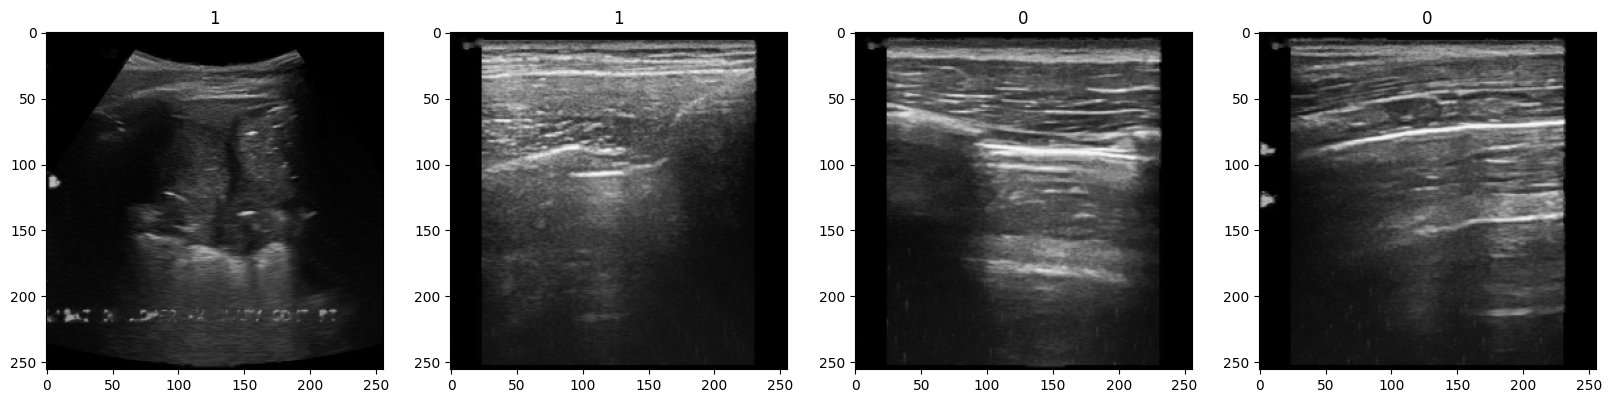

In [53]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 3. Scale Data

In [54]:
data = data.map(lambda x,y: (x/255, y))

In [55]:
data.as_numpy_iterator().next()

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

## 4. Split Data

In [56]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.15)
test_size = int(len(data)*.15)

In [57]:
train_size

16

In [58]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 5. Build Deep Learning Model

In [59]:
train

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [61]:
model = Sequential()

In [62]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [63]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14400)            

## 6. Train

In [65]:
logdir='logs'

In [66]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [67]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
16/16 [==============================] - 10s 557ms/step - loss: 0.4663 - accuracy: 0.7832 - val_loss: 0.1977 - val_accuracy: 0.9271
Epoch 2/20
16/16 [==============================] - 10s 597ms/step - loss: 0.2461 - accuracy: 0.8926 - val_loss: 0.2015 - val_accuracy: 0.9062
Epoch 3/20
16/16 [==============================] - 10s 593ms/step - loss: 0.1438 - accuracy: 0.9414 - val_loss: 0.1854 - val_accuracy: 0.9479
Epoch 4/20
16/16 [==============================] - 10s 609ms/step - loss: 0.1383 - accuracy: 0.9453 - val_loss: 0.1617 - val_accuracy: 0.9271
Epoch 5/20
16/16 [==============================] - 11s 681ms/step - loss: 0.0825 - accuracy: 0.9707 - val_loss: 0.1237 - val_accuracy: 0.9583
Epoch 6/20
16/16 [==============================] - 10s 600ms/step - loss: 0.0584 - accuracy: 0.9785 - val_loss: 0.0248 - val_accuracy: 0.9896
Epoch 7/20
16/16 [==============================] - 10s 607ms/step - loss: 0.0326 - accuracy: 0.9922 - val_loss: 0.0712 - val_accuracy: 0.9792

## 7.Plot Performance

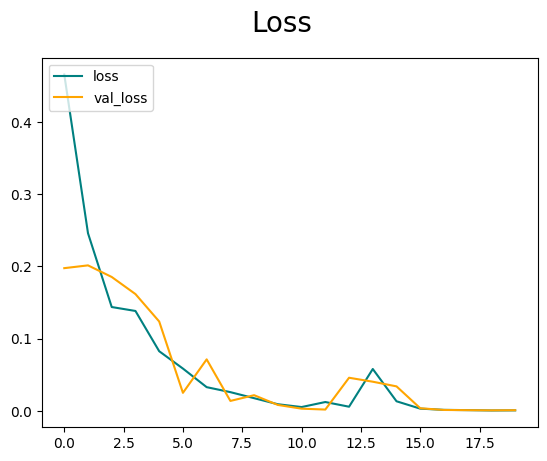

In [68]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

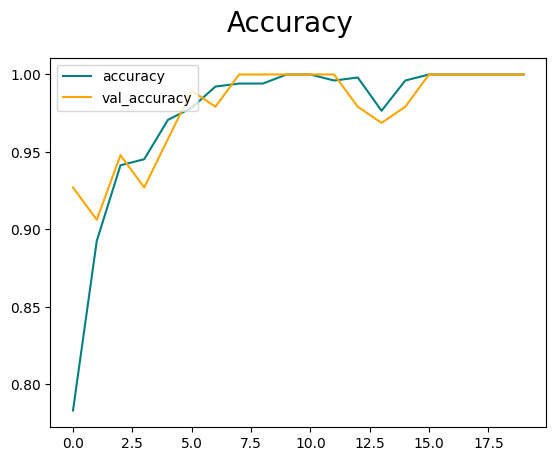

In [69]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 8.Evaluate

In [70]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [71]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [72]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [73]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


## 9.Test

In [80]:
import cv2

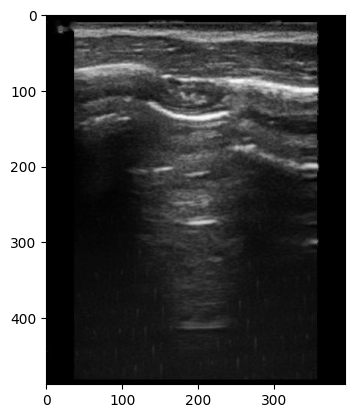

In [97]:
img = cv2.imread('dataset1/unknown_images/1.png')#dataset1/unknown_images/1.png
plt.imshow(img)
plt.show()

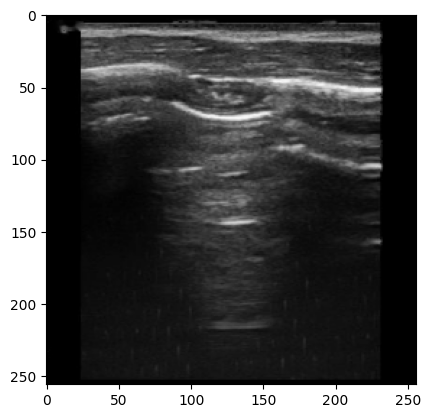

In [98]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [99]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [100]:
yhat

array([[0.2018832]], dtype=float32)

In [101]:
if yhat < 0.5: 
    print(f'Predicted class is Normal')
else:
    print(f'Predicted class is Sick')

Predicted class is Normal


## 10. Save the Model

In [102]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','dataset1model.h5'))
new_model = load_model('models/dataset1model.h5')
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.2018832]], dtype=float32)